In [3]:
import pandas as pd
from datetime import timedelta

In [18]:
sales_data = pd.read_excel('fake_data_m5.xlsx')
sales_data.dtypes

Date             datetime64[ns]
Sales                     int64
Customer Name            object
dtype: object

In [19]:
#reate a bit column indicating stockouts
sales_data['stockout'] = sales_data['Sales'].apply(lambda x: 1 if x == 0 else 0)

In [21]:
def approximate_demand(data, stockout_index):
    # Extract the date of the stockout
    stockout_date = pd.to_datetime(data['Date'].iloc[stockout_index])
    
    # Calculate the start date (15 days before the stockout)
    start_date = stockout_date - timedelta(days=15)
    
    # Calculate the end date (one day before the stockout)
    end_date = stockout_date - timedelta(days=1)
    
    # Filter data for non-stockout days within the last 15 days
    relevant_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date) & (data['stockout'] == 0)]
    
    # Calculate the average sales during these non-stockout days
    average_sales = relevant_data['Sales'].mean()
    
    # Adjust for seasonality based on the month and day of the stockout
    stockout_month = stockout_date.month
    stockout_day = stockout_date.day
    
    if stockout_month == 5 and 1 <= stockout_day <= 10:
        average_sales *= 1.25
    elif stockout_month == 6 and 1 <= stockout_day <= 10:
        average_sales *= 1.28
    elif stockout_month == 9 and 1 <= stockout_day <= 10:
        average_sales /= 1.28
    elif stockout_month == 10 and 1 <= stockout_day <= 10:
        average_sales /= 1.25
    
    return average_sales

In [22]:
# Loop through each row of the data frame to calculate the approximate demand
for i in range(len(sales_data)):
    if sales_data['stockout'][i] == 1:
        sales_data.at[i, 'Sales'] = approximate_demand(sales_data, i)

C:\Users\KerimMasovic\AppData\Local\Temp\ipykernel_30908\611971605.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '32.13333333333333' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sales_data.at[i, 'Sales'] = approximate_demand(sales_data, i)


In [23]:
#round
sales_data["Sales"] = sales_data['Sales'].apply(lambda x: round(x))
# Remove stockout column since we do not need it anymore
sales_data.drop(columns=['stockout'], inplace=True)

# Plot the new data
# Create a Month-Year column for grouping
sales_data['MonthYear'] = sales_data['Date'].dt.strftime('%b-%Y')

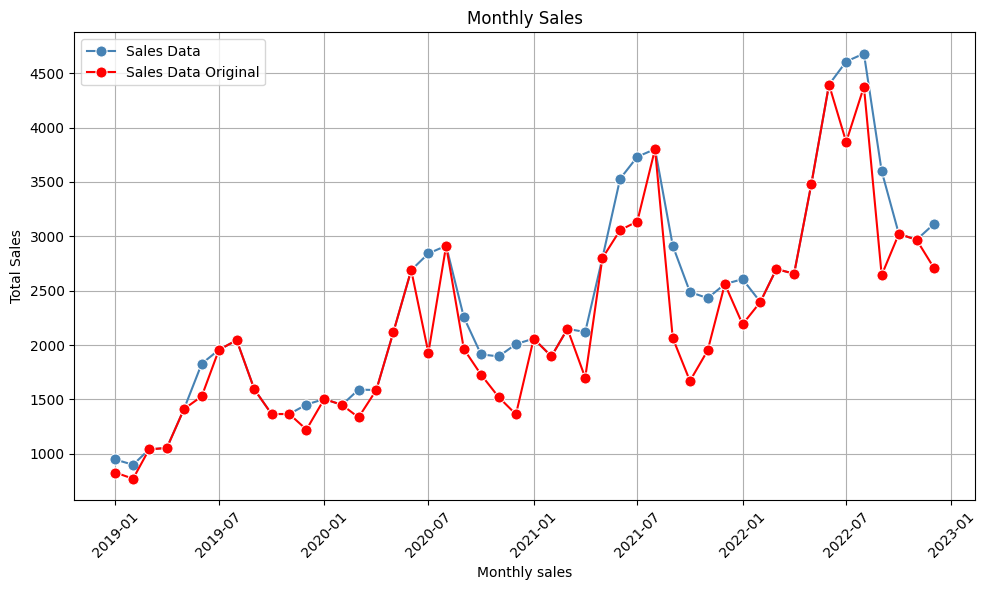

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

# Convert Date column to Month-Year format
sales_data['MonthYear'] = sales_data['Date'].dt.strftime('%b-%Y')

# Group by MonthYear and calculate total sales
monthly_sales = sales_data.groupby('MonthYear').agg({'Date': 'min', 'Sales': 'sum'}).reset_index()
monthly_sales['Date'] = pd.to_datetime(monthly_sales['Date'])

sales_data_org = pd.read_excel('fake_data_m5.xlsx')
# Convert Date column to Month-Year format
sales_data_org['MonthYear'] = sales_data_org['Date'].dt.strftime('%b-%Y')

# Group by MonthYear and calculate total sales
sales_data_org = sales_data_org.groupby('MonthYear').agg({'Date': 'min', 'Sales': 'sum'}).reset_index()
sales_data_org = sales_data_org[sales_data_org['Date'] < '2023-01-01']

# Filter data for dates before '2023-01-01'
monthly_sales = monthly_sales[monthly_sales['Date'] < '2023-01-01']

# Plot the graph
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Sales', data=monthly_sales, color='steelblue', marker='o', markersize=8, label='Sales Data')
sns.lineplot(x='Date', y='Sales', data=sales_data_org, color='red', marker='o', markersize=8, label='Sales Data Original')
plt.title('Monthly Sales')
plt.xlabel('Monthly sales')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
